In [1]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import optax

import numpy as np

from pymatching import Matching

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(42)

# Initialize the QEC code that will be used

Rate of non-trivial cases: 99.43%


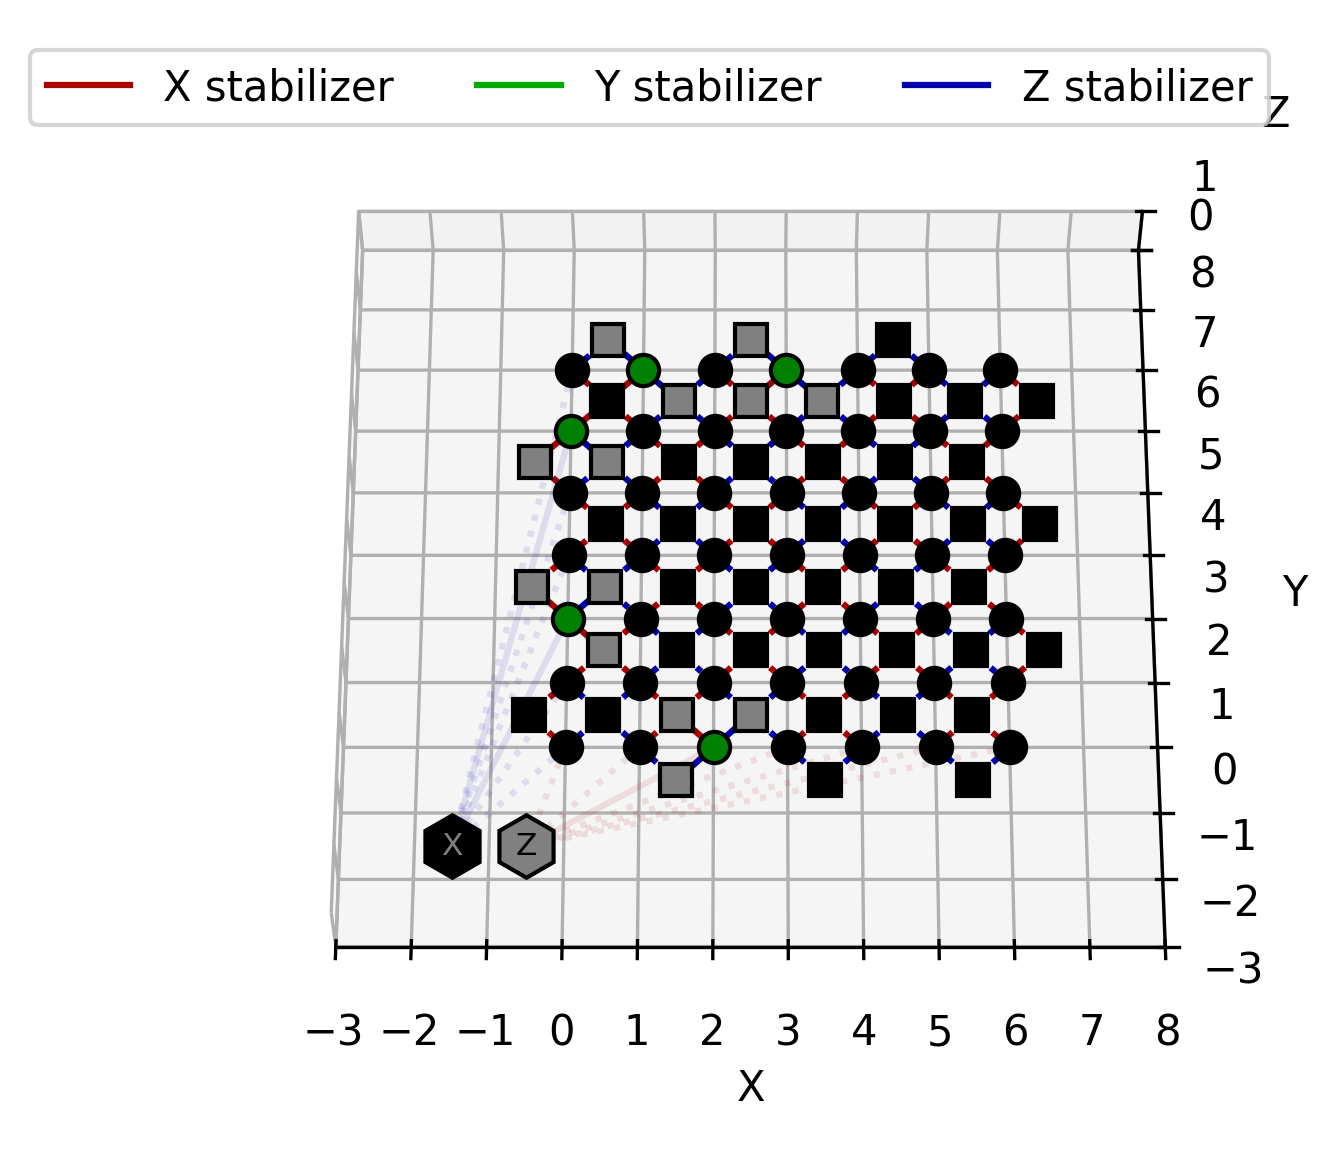

In [2]:
error_prob = [.0, .1, .0]
code_distance = 7

subkey, key = jax.random.split(key)
errors = jax_create_error_batch(*error_prob, size=code_distance**2, batch_size=1, key=subkey)

qec = QEC(surface_code_data_wls(d=code_distance))
info = {}
info['Mx'], info['My'], info['Mz'] = qec.transformation_matrix()
# Split into matrix for syndrome qubits in logical detectors
info['Sx'], info['Lx'] = info['Mx'][:-2], info['Mx'][-2:]
info['Sy'], info['Ly'] = info['My'][:-2], info['My'][-2:]
info['Sz'], info['Lz'] = info['Mz'][:-2], info['Mz'][-2:]
nsq, ndq = info['Sx'].shape
qec.show(errors=errors[0]);

print(f'Rate of non-trivial cases: {1-(1-sum(error_prob))**ndq:.2%}')

syndromes = jax_get_syndromes_batch(info['Sx'], info['Sy'], info['Sz'], errors)
code_logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], errors)

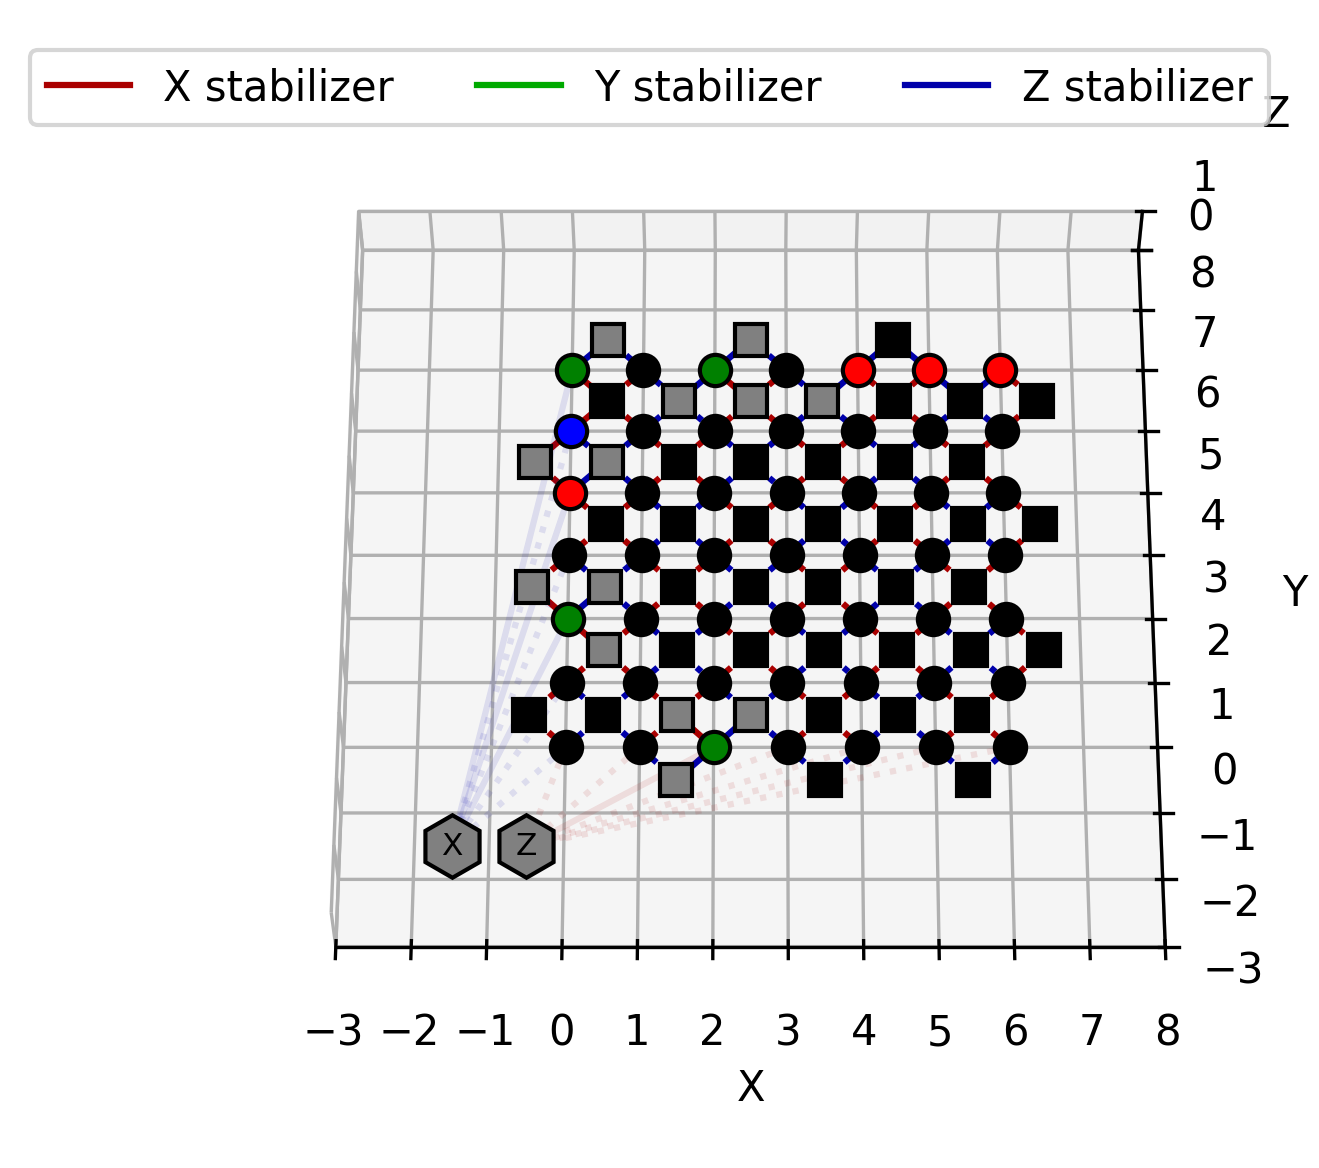

In [3]:
def simple_decode(syndromes: jnp.ndarray, info: dict, code_distance: int, mistakes = [False, False]) -> jnp.ndarray:
    xmask = jnp.where(info['Sx'].sum(axis=1) > 0)
    zmask = jnp.where(info['Sz'].sum(axis=1) > 0)
    a, b = (code_distance+1)//2, code_distance-1

    # Get the x-syndromes
    xblock = syndromes[xmask].reshape((b,a)).T
    # Calculate x-action
    xblock_left = xblock[:,:b//2]
    xactions_left = jnp.cumsum(xblock_left[:, ::-1], axis=1)[:, ::-1]
    xblock_right = xblock[:,b//2:]
    xactions_right = jnp.cumsum(xblock_right[:, :], axis=1)[:, :]
    # Calculate x-recovery
    xrecovery = jnp.zeros((code_distance, code_distance), dtype=int) \
        .at[::2, :b//2].set(xactions_left%2) \
        .at[::2, b//2+1:].set(xactions_right%2).T
    # Adds the logical x operator to fix the logical x error
    if mistakes[0]:
        xrecovery = xrecovery.at[:,a-1].add(1) % 2

    # Get the z-syndromes
    zblock_ = syndromes[zmask].reshape((a,b)).T
    # Fiz ordering
    zblock = jnp.zeros_like(zblock_)
    zblock = zblock.at[::2, :].set(zblock_[:b//2, :])
    zblock = zblock.at[1::2, :].set(zblock_[b//2:, :])
    # Calculate z-action
    zblock_top = zblock[b//2:, :]
    zactions_top = jnp.cumsum(zblock_top[:, :], axis=0)[:, :]
    zblock_bottom = zblock[:b//2, :]
    zactions_bottom = jnp.cumsum(zblock_bottom[::-1, :], axis=0)[::-1, :]
    # Caclculate z-recovery
    zrecovery = jnp.zeros((code_distance, code_distance), dtype=int) \
        .at[b//2+1:, ::2].set(zactions_top%2) \
        .at[:b//2, ::2].set(zactions_bottom%2).T
    # Adds the logical z operator to fix the logical z error
    if mistakes[1]:
        zrecovery = zrecovery.at[a-1,:].add(1) % 2

    # Combine the x and z corrections to obtain the full recovery procedure
    xrecovery = xrecovery.reshape(code_distance**2)
    zrecovery = zrecovery.reshape(code_distance**2)
    recovery = jnp.where(xrecovery==1, jnp.where(zrecovery==1, 2, 1), jnp.where(zrecovery==1, 3, 0))
    return recovery

simple_decode_batch = jax.vmap(
    simple_decode,
    in_axes=(0, None, None),
    out_axes=0
)

# simple_recovery = simple_decode_batch(syndromes, info, code_distance)
# qec.show(errors=simple_recovery[0]);
qec.show(errors=simple_decode(syndromes[0], info, code_distance, mistakes=[False, False]));

# Decode the SC

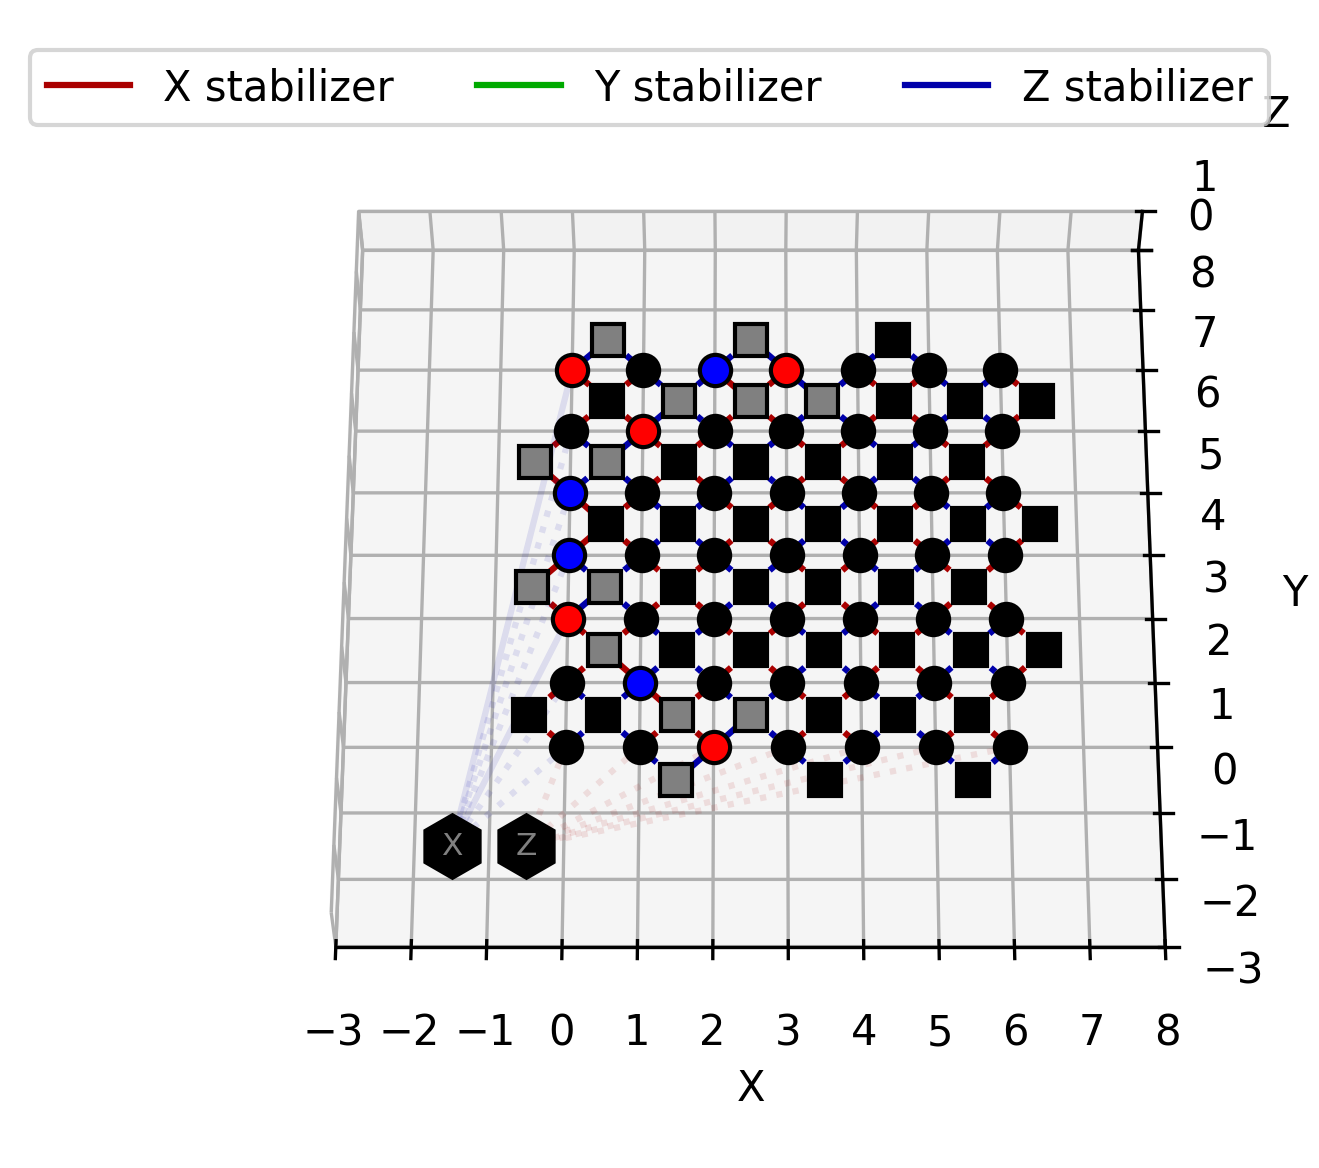

In [4]:
MWPM = Matching(jnp.append(info['Sx'], info['Sz'], axis=1))
decoding = MWPM.decode_batch(syndromes)
recovery = jnp.where(
    decoding[:,:ndq]==1, 
    jnp.where(decoding[:,ndq:]==1, 2, 1), 
    jnp.where(decoding[:,ndq:]==1, 3, 0)
)
qec.show(errors=recovery[0]);
mwpm_logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], recovery)

# Create data function

In [5]:
def jax_create_error(px: float, py: float, pz: float, size: int, key) -> jnp.ndarray:
    rand = jax.random.uniform(key, shape=(size))
    return jnp.where(rand < py+pz, jnp.where(rand < pz, 3, 2), jnp.where(rand < px+py+pz, 1, 0))


def jax_create_error_batch(px: jnp.ndarray, py: jnp.ndarray, pz: jnp.ndarray, size: int, batch_size: int, key) -> jnp.ndarray:
    keys = jax.random.split(key, batch_size)
    batch_created_errors = jax.vmap(
        jax_create_error,
        in_axes=(0, 0, 0, None, 0),
        out_axes=0)
    return batch_created_errors(px, py, pz, size, keys)


def gen_data(error_probs: jnp.ndarray, info: dict, ndq: int, batch_size: int, key):
    errors = jax_create_error_batch(error_probs[:,0], error_probs[:,1], error_probs[:,2], size=ndq, batch_size=batch_size, key=key)

    syndromes = jax_get_syndromes_batch(info['Sx'], info['Sy'], info['Sz'], errors)
    code_logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], errors)

    recovery = simple_decode_batch(syndromes, info, code_distance)
    simple_logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], recovery)

    return syndromes, (code_logicals + simple_logicals) % 2, errors


batch_size = 2

# Create error_probs in specific range
subkey, key = jax.random.split(key)
error_probs = jax.random.uniform(key=subkey, minval=.0001, maxval=.05, shape=(batch_size, 3))
print(error_probs)

# Generate data
subkey, key = jax.random.split(key)
gen_data(error_probs, info, ndq, batch_size=batch_size, key=subkey)

[[0.04489943 0.04982699 0.0447578 ]
 [0.03896942 0.04579744 0.03507508]]


(Array([[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
         0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
         0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
         1, 0, 0, 0]], dtype=int32),
 Array([[1, 1],
        [0, 0]], dtype=int32),
 Array([[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2,
         0, 0, 2, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0,
         0, 0, 0, 0, 0]], dtype=int32, weak_type=True))

# Create the NN

In [6]:
def NN(x, params, trianing=True):
    """
    Standard multilayer perception "MLP" with params['weights'] and params['biases'],
    applied to input vector x. Activation tanh applied to all
    layers except last.

    Returns activation vector of the output layer.
    """
    # Change from 0, 1 inputs to -1, 1
    x = 2*x - 1

    num_layers = len(params['weights'])
    for layer_idx, (w, b) in enumerate(zip(params['weights'], params['biases'])):
        x = jnp.matmul(w, x) + b
        if layer_idx < num_layers-1:
            x = jax.nn.relu(x)
            # x = jnp.tanh(x)
        else:
            if not trianing:
                x = jax.nn.sigmoid(x)
    return x


NN_batch = jax.vmap(NN, in_axes=[0, None], out_axes=0)

# Initialize the NN
with random weights and biases

In [7]:
subkey, key = jax.random.split(key)
# num_neurons_layers = [nsq, (nsq+2)//2, 2]
num_neurons_layers = [nsq+3, 64, 32, 16, 8, 4, 2]
params = NN_init_params( subkey, num_neurons_layers )
print(f"Layers: {num_neurons_layers}")

Layers: [51, 64, 32, 16, 8, 4, 2]


# Cost function

In [8]:
def mse_loss_batch(NN_input: jnp.ndarray, params: dict, logicals: jnp.ndarray) -> jnp.ndarray:
    """
    Uses the Binary Cross Entropy (BCE) to evaluate the performance of the NN
    """
    NN_logicals = NN_batch(NN_input, params)
    return optax.sigmoid_binary_cross_entropy(NN_logicals, logicals).mean()

mse_loss_batch_val_grad = value_and_grad(mse_loss_batch, argnums=1)
mse_loss_batch_val_grad = jax.jit(mse_loss_batch_val_grad)

# Test it on the randomly initiated NN

In [9]:
batch_size = 10_000

# Create error_probs in specific range
subkey, key = jax.random.split(key)
error_probs = jax.random.uniform(key=subkey, minval=.0001, maxval=.05, shape=(batch_size, 3))

# Generate data
subkey, key = jax.random.split(key)
syndromes, logicals, _ = gen_data(error_probs, info, ndq, batch_size=batch_size, key=subkey)

# Run the neural network
NN_logicals = NN_batch(jnp.append(syndromes, error_probs, axis=1), params)
print(NN_logicals[:5])

# Evaluate the neural networks performance
mse_loss_batch(jnp.append(syndromes, error_probs, axis=1), params, logicals)

[[ 0.          0.        ]
 [-0.02343669  0.04139677]
 [-0.00872374  0.01540895]
 [-0.01156741  0.02043178]
 [-0.01247457  0.01915755]]


Array(0.6936042, dtype=float32)

# Train the NN

In [10]:
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# training parameters
max_training_batches = 1_000_000
max_training_time = 60*60 # in seconds
batch_size = 32
error_prob = [.01, .01, .01]
losses=[]
idx_batch = 0

num_batch_generation_size = 100_000 // batch_size
print(num_batch_generation_size)

3125


In [15]:
from IPython.display import clear_output
from time import time

T = {
    'Data generation ': 0, 
    'loss + grad calc': 0, 
    'Safe guard      ': 0, 
    'Update          ': 0, 
    'Store           ': 0}
start_time = time()

while True: 
    try:
        t0 = time()

        # Generate data
        if idx_batch % num_batch_generation_size == 0:
            if idx_batch > 0:
                s = 50000
                losses_ = losses[-2*s-1::10]
                improvement_rate, _ = np.polyfit(np.arange(0,len(losses_),1), losses_, deg=1)
                loss = np.mean(losses_)
                print(f"{loss = :7.5f} with an improvement rate of {improvement_rate:9.2E}")
                if improvement_rate > 0: # No improvement seen in the last 2s rounds of training
                    print("Training has platoed.")
                    break
            # Create error_probs in specific range
            subkey, key = jax.random.split(key)
            error_probs_ = jax.random.uniform(key=subkey, minval=.0001, maxval=.05, shape=(num_batch_generation_size*batch_size, 3))

            # Generate data
            subkey, key = jax.random.split(key)
            syndromes_, logicals_, _ = gen_data(error_probs_, info, ndq, batch_size=num_batch_generation_size*batch_size, key=subkey)
        # Pick out datablock
        start = (idx_batch%num_batch_generation_size)*batch_size
        end = ((idx_batch%num_batch_generation_size)+1)*batch_size
        error_probs = error_probs_[start:end]
        syndromes = syndromes_[start:end]
        logicals = logicals_[start:end]

        t1 = time()
        T['Data generation '] += t1 - t0
        t0 = t1
        
        # get loss and its gradient with respect to network parameters:
        loss, grads = mse_loss_batch_val_grad(jnp.append(syndromes, error_probs, axis=1), params, logicals)

        t1 = time()
        T['loss + grad calc'] += t1 - t0
        t0 = t1

        # Safe-guard against nan values
        # Stops the training before updating with problematic prams
        if jnp.isnan(loss) or any([jnp.isnan(bias).any() for bias in grads['weights']]):
            print('Got nan values at batch id:', idx_batch)
            break
        if time() - start_time > max_training_time:
            print('Surpassed the specified training time')
            break

        t1 = time()
        T['Safe guard      '] += t1 - t0
        t0 = t1

        # update the network parameters:
        updates, opt_state = optimizer.update( grads, opt_state )
        params = optax.apply_updates( params, updates )

        t1 = time()
        T['Update          '] += t1 - t0
        t0 = t1

        # add the loss to the list:
        losses.append(loss)
        idx_batch += 1

        t1 = time()
        T['Store           '] += t1 - t0
        t0 = t1
    except KeyboardInterrupt:
        print('Manually stopped')
        break


loss = 0.07377 with an improvement rate of -3.10E-07
loss = 0.07363 with an improvement rate of -3.13E-07
loss = 0.07349 with an improvement rate of -3.33E-07
loss = 0.07324 with an improvement rate of -4.02E-07
loss = 0.07333 with an improvement rate of -2.11E-07
loss = 0.07305 with an improvement rate of -2.86E-07
loss = 0.07300 with an improvement rate of -2.47E-07
loss = 0.07282 with an improvement rate of -2.43E-07
loss = 0.07283 with an improvement rate of -4.13E-07
loss = 0.07273 with an improvement rate of -1.89E-07
loss = 0.07275 with an improvement rate of -2.38E-07
loss = 0.07263 with an improvement rate of -2.90E-07
loss = 0.07225 with an improvement rate of -3.98E-07
loss = 0.07248 with an improvement rate of -2.24E-07
loss = 0.07237 with an improvement rate of -4.77E-07
loss = 0.07221 with an improvement rate of -2.41E-07
loss = 0.07231 with an improvement rate of -4.86E-07
loss = 0.07216 with an improvement rate of -3.32E-07
loss = 0.07200 with an improvement rate of -4.

In [16]:
for k,v in T.items():
    print(f"{k} {v:10.3f}s ({v/sum(T.values()):6.2%})")

Data generation      36.551s ( 6.79%)
loss + grad calc      8.941s ( 1.66%)
Safe guard           30.327s ( 5.63%)
Update              462.055s (85.82%)
Store                 0.544s ( 0.10%)


In [17]:
NN_name = f"Predicter_L_{'_'.join([str(v) for v in num_neurons_layers])}"
print(NN_name)

Predicter_L_51_64_32_16_8_4_2


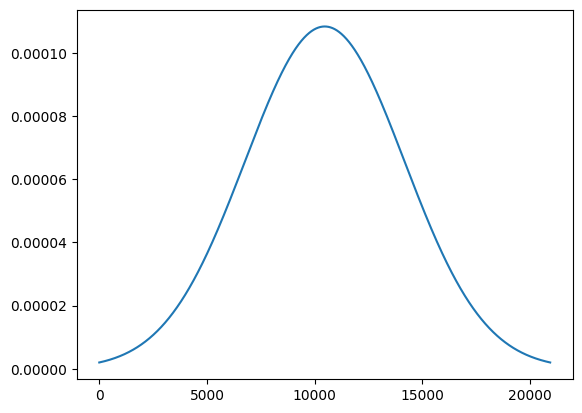

In [18]:
window_size = len(losses) // 20
window_xs = np.linspace(-2, 2, window_size)
window_form = jnp.exp(-window_xs**2)
window = window_form / sum(window_form)

plt.plot(range(window_size), window)

In [19]:
losses_jax = jnp.array(losses)
losses_ = jnp.ones(shape=(losses_jax.shape[0]+2*window_size))
a = window_size
b = a + losses_jax.shape[0]
losses_ = losses_.at[a:b].set(losses_jax)
losses_ = losses_.at[:a].set(losses_jax[:a][::-1])
losses_ = losses_.at[b:].set(losses_jax[-a:][::-1])
running_avg = jnp.convolve(losses_, window, mode='same')[a:b]

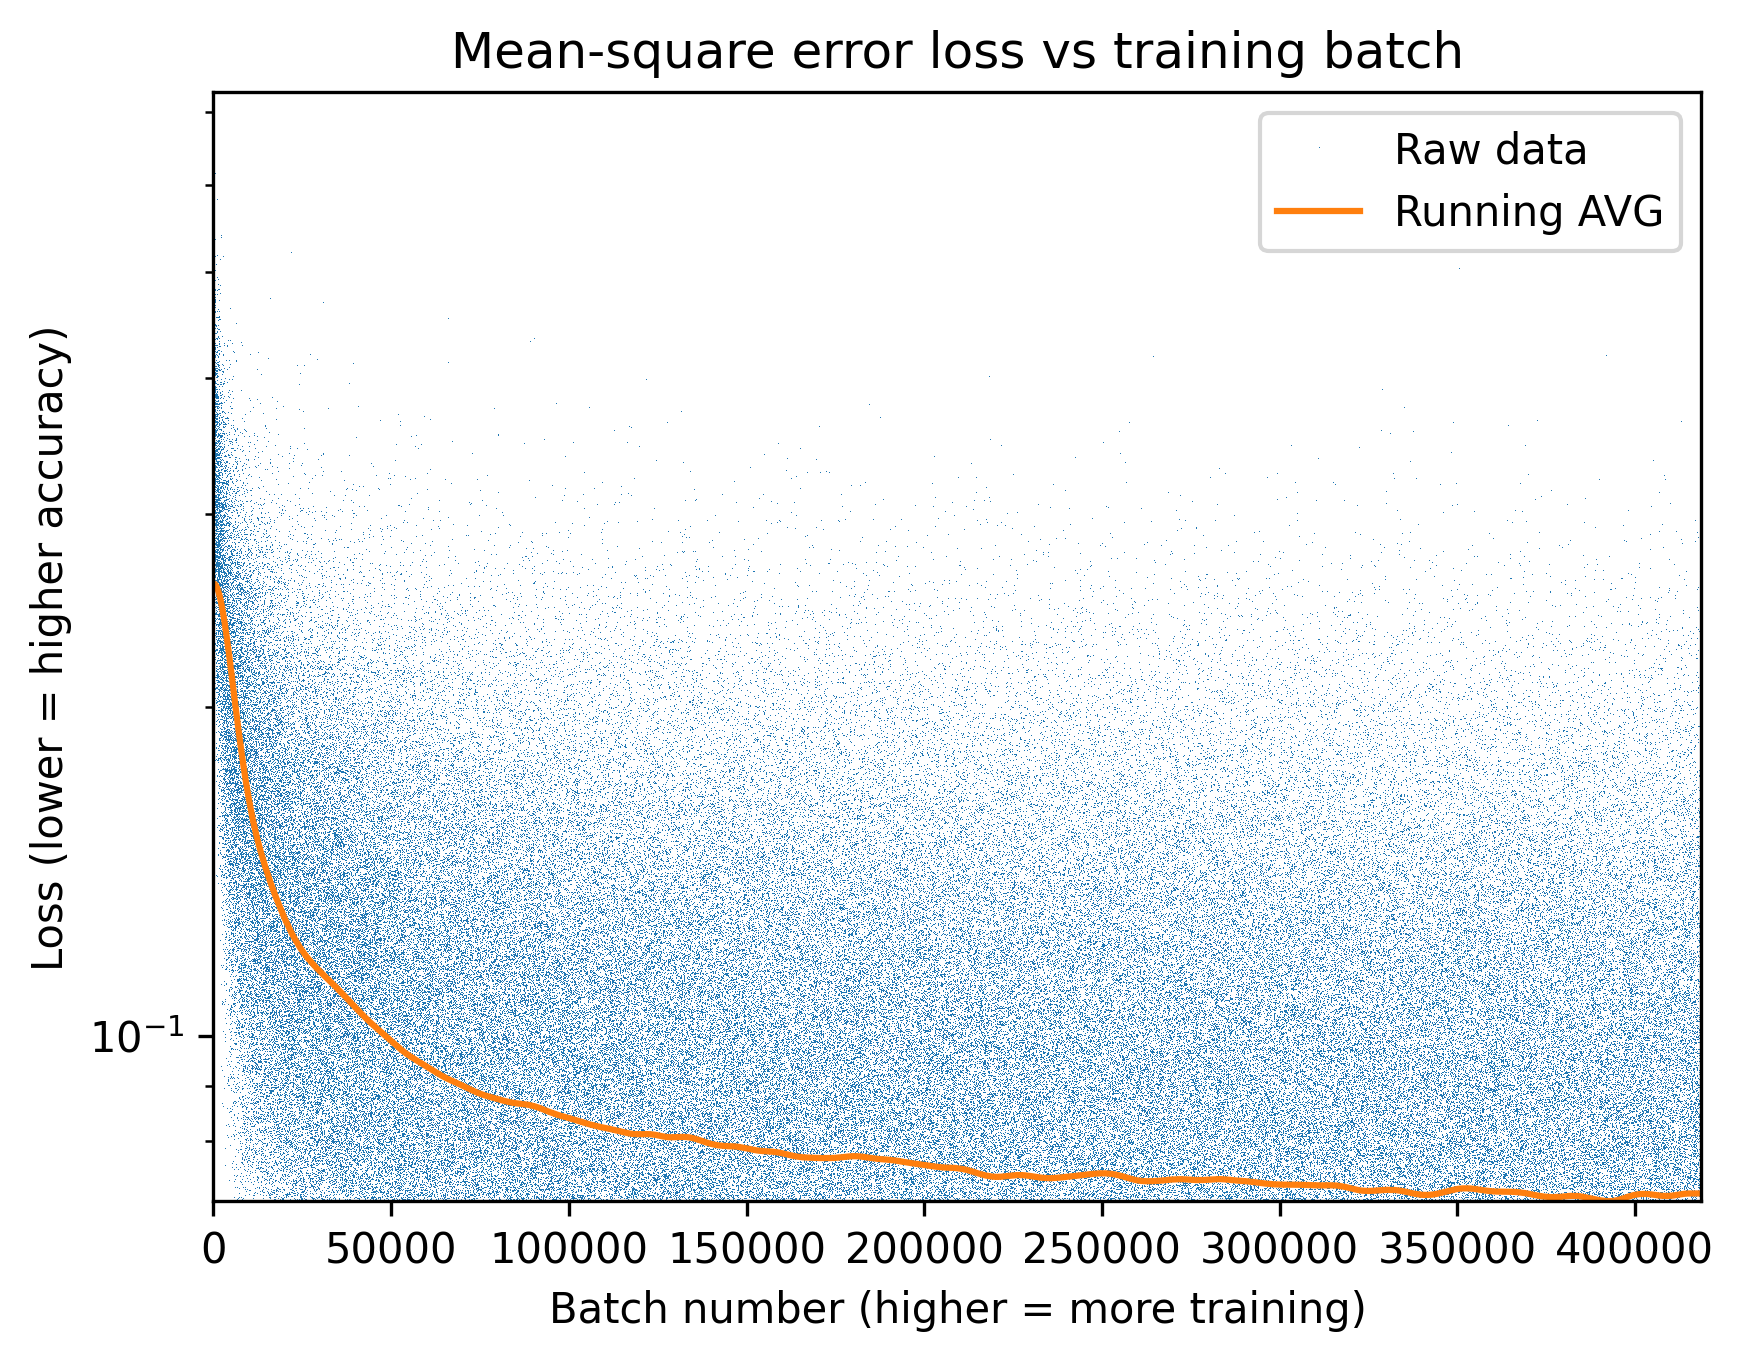

In [20]:
plt.figure(dpi=300)
plt.plot(jnp.arange(0, len(losses)), losses, ',', label="Raw data")
plt.plot(jnp.arange(0, len(losses)), running_avg, label="Running AVG")
plt.xlim(0, len(losses))
plt.ylim(ymin = running_avg.min())
plt.legend()
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.xlabel("Batch number (higher = more training)")
plt.ylabel("Loss (lower = higher accuracy)")
plt.savefig(NN_name+"_Loss.png", dpi=300)
plt.show()

In [22]:
save_NN(NN_name+'_params.json', params)

In [37]:
batch_size = 1_000_000

# Create error_probs in specific range
subkey, key = jax.random.split(key)
error_probs = jax.random.uniform(key=subkey, minval=.0001, maxval=.05, shape=(batch_size, 3))
# error_probs = jnp.ones(shape=(batch_size, 3)) * jnp.array([.005,.05,.005])

# Generate data
subkey, key = jax.random.split(key)
syndromes, logicals, errors = gen_data(error_probs, info, ndq, batch_size=batch_size, key=subkey)

# Run the neural network and round it's prediction to the nearest integer
NN_logicals = jnp.where(jax.nn.sigmoid(NN_batch(jnp.append(syndromes, error_probs, axis=1), params)) > .5, 1, 0)

# Calculate the 2d histogram that correlates the actual logicals with the NN prediction
i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * NN_logicals[:, 0] + NN_logicals[:, 1]
hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

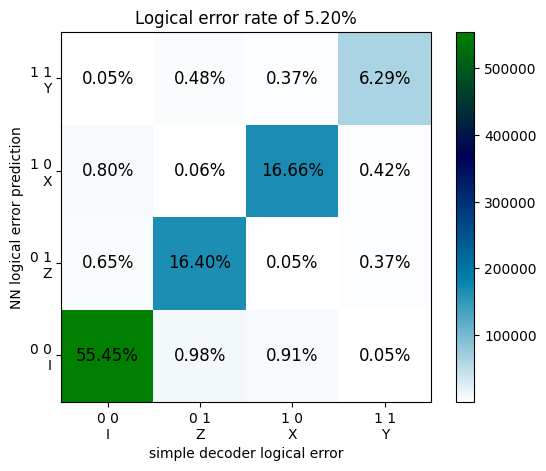

In [38]:
import matplotlib.colors

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plt.figure()
img = plt.imshow(hist2d, origin='lower', cmap='ocean_r')
plt.colorbar(img)
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.xlabel('simple decoder logical error')
plt.ylabel('NN logical error prediction')
for x, row in enumerate(jnp.array(hist2d).T):
    for y, count in enumerate(row):
        plt.text(x, y, f'{count/hist2d.sum():.2%}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
        # plt.text(x-.2, y+.2, f'{count/hist2d[:,y].sum():.2%}', ha='center', va='center', rotation=45, rotation_mode='anchor')
        # plt.text(x+.2, y-.2, f'{count/hist2d[x,:].sum():.2%}', ha='center', va='center', rotation=45, rotation_mode='anchor')
plt.title(f'Logical error rate of {1 - hist2d.diagonal().sum() / hist2d.sum():.2%}')
plt.savefig(NN_name+"_hist2d.png", dpi=300)
plt.show()

In [39]:
# Evaluate the MWPM decoder on the same dataset
MWPM = Matching(jnp.append(info['Sx'], info['Sz'], axis=1))
decoding = MWPM.decode_batch(syndromes)
recovery = jnp.where(decoding[:,:ndq]==1, jnp.where(decoding[:,ndq:]==1, 2, 1), jnp.where(decoding[:,ndq:]==1, 3, 0))
mwpm_logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], recovery)
code_logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], errors)

In [40]:
print(f"The physical error rate is:                           {error_prob}")
print(f"The logical error rate without the NN correction:     {(logicals.sum(axis=1) > 0).mean():6.2%}")
print(f"The logical error rate with the NN correction:        {(((logicals+NN_logicals)%2).sum(axis=1) > 0).mean():6.2%}")
print(f"The logical error with MWPM decoding:                 {(((code_logicals+mwpm_logicals)%2).sum(axis=1) > 0).mean():6.2%}")
with open(NN_name+"_scores.txt", 'w') as file:
    file.write(
        f"The logical error rate without the NN correction:     {(logicals.sum(axis=1) > 0).mean():6.2%}\nThe logical error rate with the NN correction:        {(((logicals+NN_logicals)%2).sum(axis=1) > 0).mean():6.2%}\nThe logical error with MWPM decoding:                 {(((code_logicals+mwpm_logicals)%2).sum(axis=1) > 0).mean():6.2%}"
    )

The physical error rate is:                           [0.01, 0.01, 0.01]
The logical error rate without the NN correction:     43.04%
The logical error rate with the NN correction:         5.20%
The logical error with MWPM decoding:                  4.84%


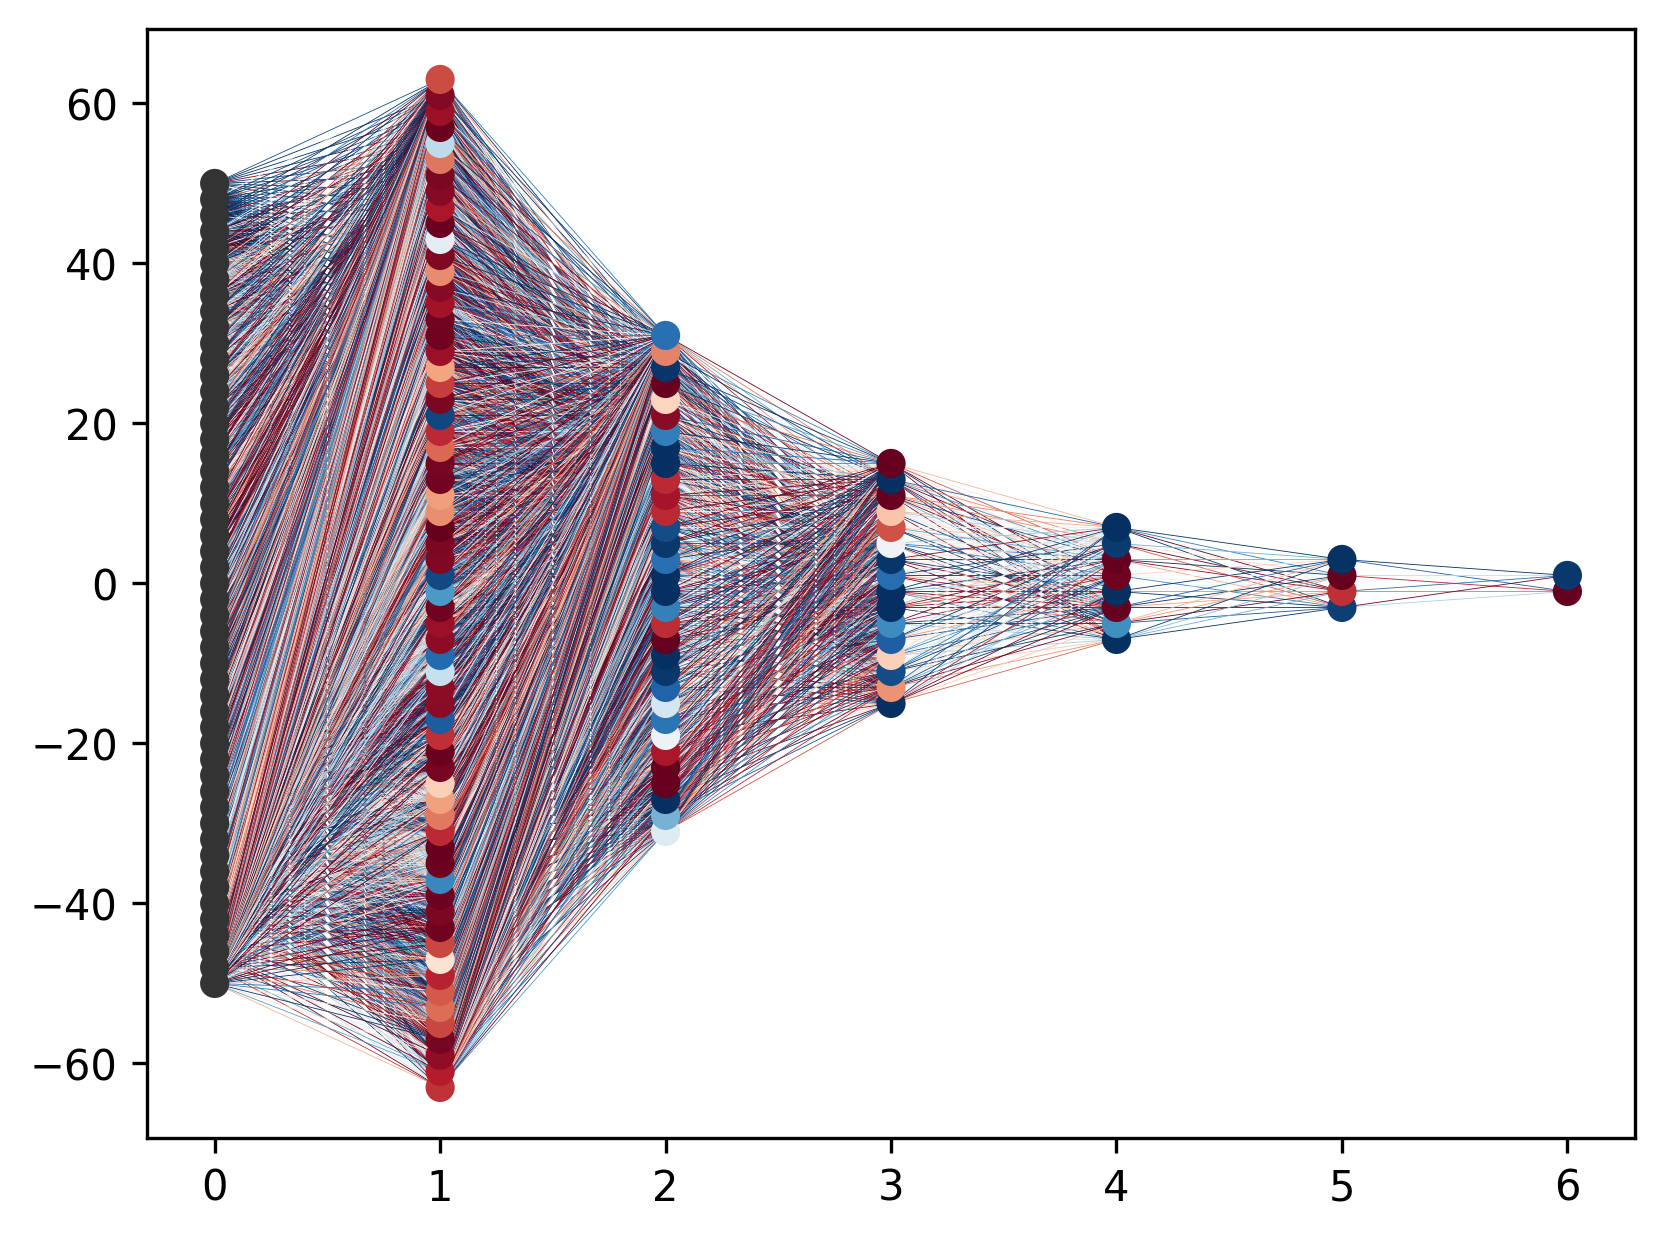

In [41]:
import matplotlib as mpl

cmap = mpl.colormaps['RdBu']
cmap.set_bad([0.2,0.2,0.2,1])

plt.figure(dpi=300)

ys = []
for i, n in enumerate(num_neurons_layers):
    y = jnp.linspace(-(n-1),(n-1),n)
    ys.append(y)
    x = i*jnp.ones_like(y)
    if i == 0:
        b = jnp.nan*jnp.ones_like(y)
    else:
        b = params['biases'][i-1]
        for l in range(num_neurons_layers[i]):
            for m in range(num_neurons_layers[i-1]):
                plt.plot([i-1, i], [ys[i-1][m], ys[i][l]], color=cmap(sigmoid(10*params['weights'][i-1][l,m])), lw=.2, zorder=1)
    plt.scatter(x, y, c=cmap(sigmoid(4*b)), zorder=2)

plt.show()

In [42]:
jnp.where(((logicals+NN_logicals)%2).sum(axis=1) > 0)

(Array([    57,     66,     77, ..., 999951, 999963, 999996], dtype=int32),)

In [43]:
jnp.where(((code_logicals+mwpm_logicals)%2).sum(axis=1) > 0)

(Array([    14,     57,     60, ..., 999965, 999994, 999996], dtype=int32),)

In [44]:
jnp.where((errors > 0).sum(axis=1) == 1)

(Array([     5,      8,     12, ..., 999926, 999952, 999964], dtype=int32),)

/home/Julius/Documents/Python venv/Thesis/lib/python3.13/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/tmp/ipykernel_408337/1394553840.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


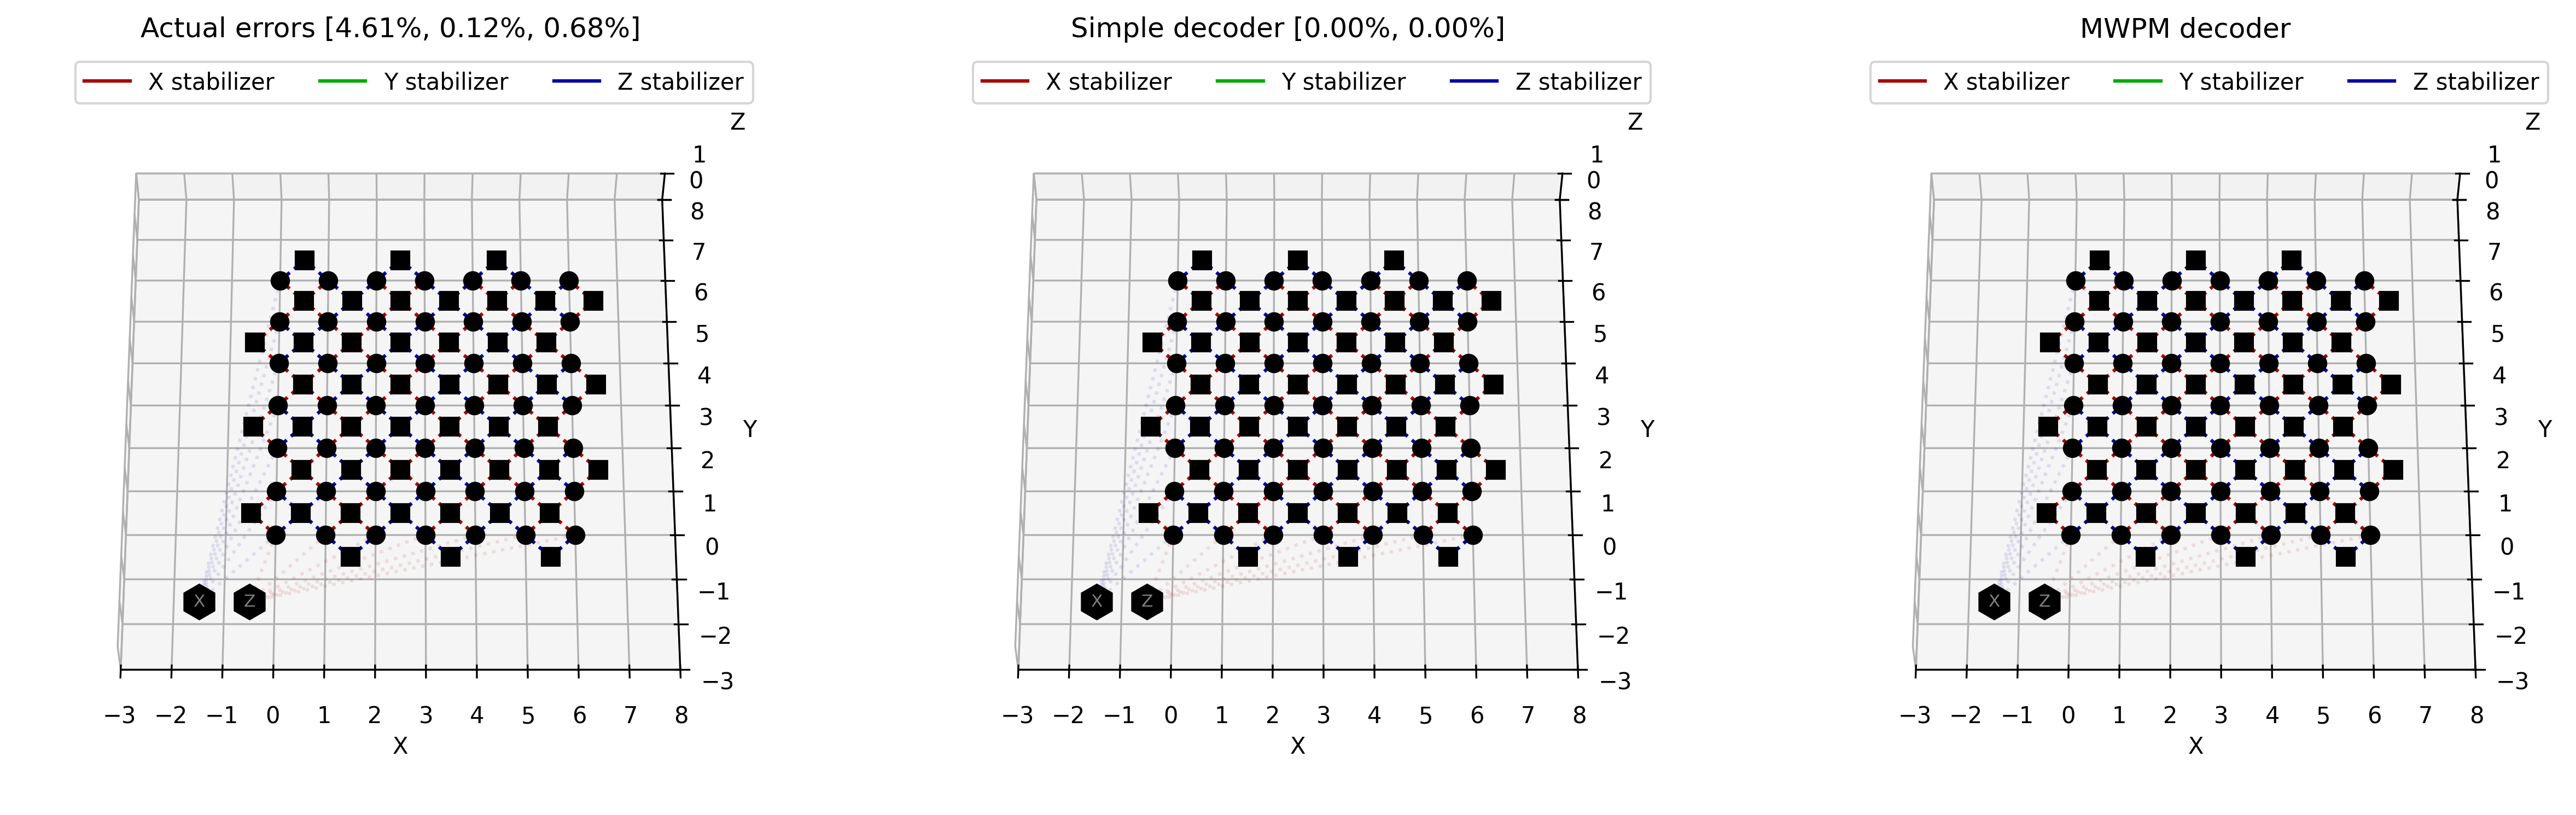

In [45]:
idx = 23
NN_prediction = jax.nn.sigmoid(NN(jnp.append(syndromes, error_probs, axis=1)[idx], params))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, subplot_kw={'projection': '3d'})
fig.set_dpi(300)
fig.set_figwidth(20)
fig.set_figheight(8)
qec.show(axis=ax1, errors=errors[idx], title=f"Actual errors [{', '.join([f'{v:.2%}' for v in error_probs[idx]])}]");
# qec.show(axis=ax2, errors=simple_decode(jnp.append(syndromes, error_probs, axis=1)[idx], info, code_distance), title=f"Simple decoder [{', '.join([f'{v:.2%}' for v in NN_prediction])}]");
qec.show(axis=ax2, errors=simple_decode(jnp.append(syndromes, error_probs, axis=1)[idx], info, code_distance, mistakes=jnp.where(NN_prediction > .5, True, False)), title=f"Simple decoder [{', '.join([f'{v:.2%}' for v in NN_prediction])}]");
qec.show(axis=ax3, errors=recovery[idx], title="MWPM decoder");
fig.show()

/home/Julius/Documents/Python venv/Thesis/lib/python3.13/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


<Axes3D: title={'center': 'Simple decoder [0.06%, 12.02%]'}, xlabel='X', ylabel='Y', zlabel='Z'>

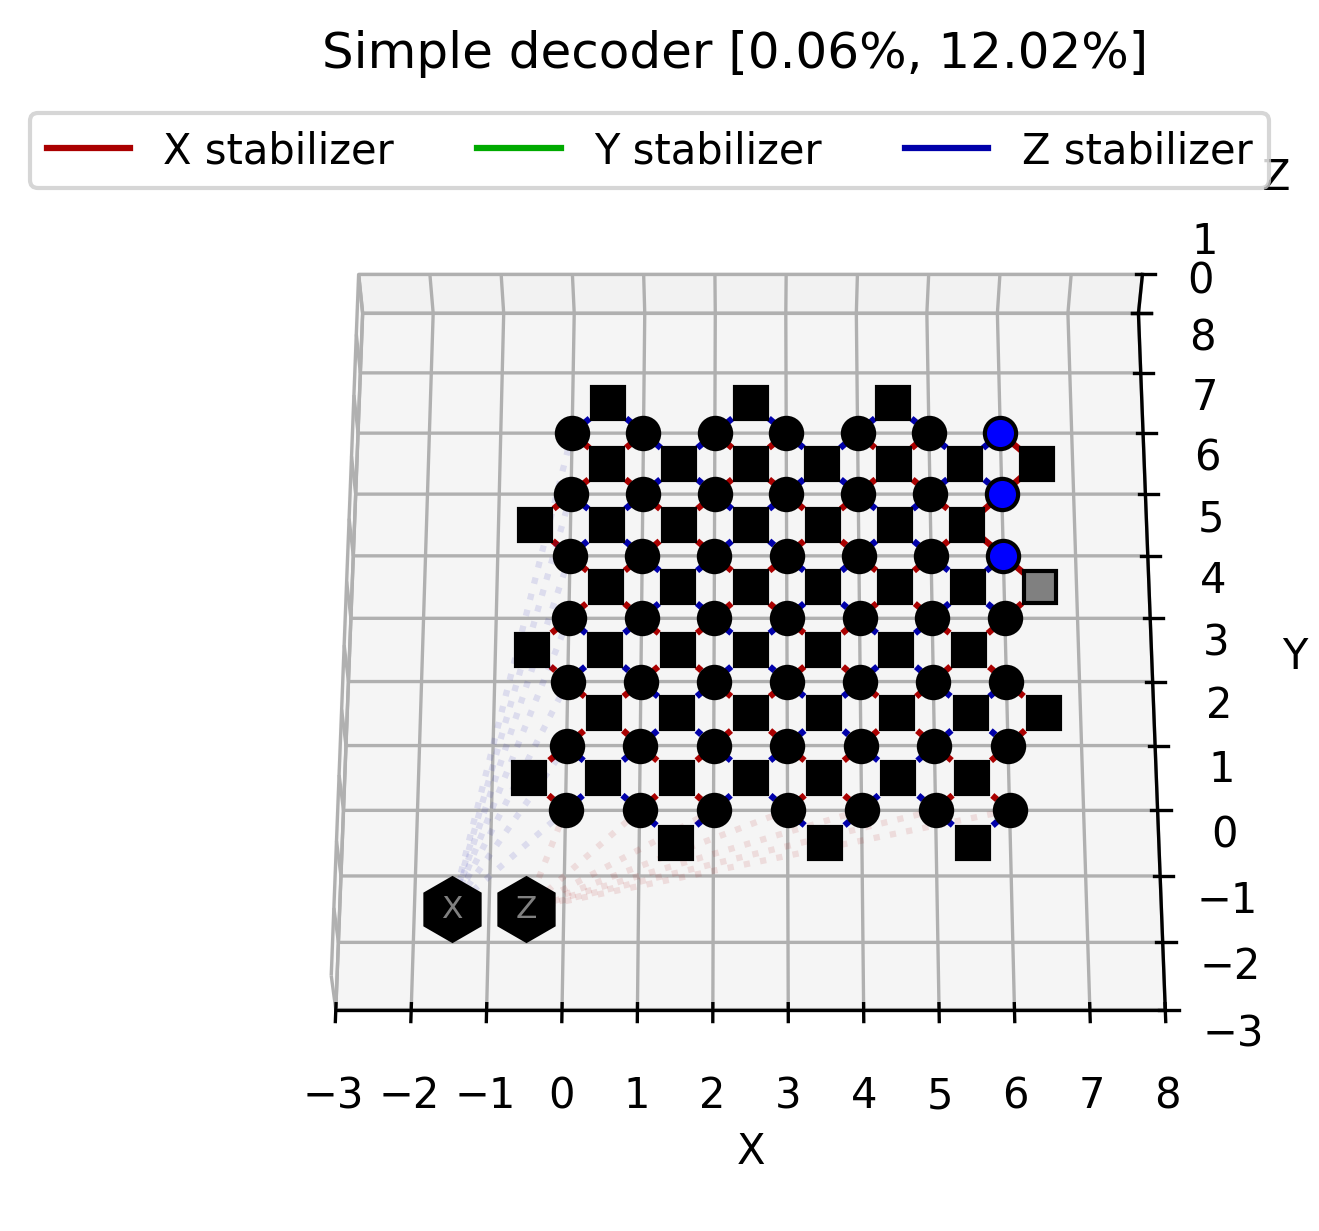

In [35]:
i = 46
synd = jnp.zeros(shape=(code_distance**2-1)).at[i].set(1)
qec.show(errors=simple_decode(synd, info, code_distance), title=f"Simple decoder [{', '.join([f'{v:.2%}' for v in jax.nn.sigmoid(NN(jnp.append(synd, jnp.array([.01, .01, .01])), params))])}]")